In [1]:
#@title Task 0: Prepare all the utility functions and packages for task 1 and 2.

In [2]:
#@title Step 1: Import all necessary libraries (ok).
# General python library (ok).
import os
import cv2
import numpy as np
from PIL import Image, ImageEnhance
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import time

# Torch library (ok).
import torch
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import nn
from torchvision import datasets, transforms as tfs
import torch.nn.init as init


In [3]:
#@title Step 2: Define utility functions (ok).
# Define training function (ok).
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# Define error_performance function (ok).
def error_performance(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    if dataloader.dataset.train == True: print(f"----> Train accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}!")
    else: print(f"----> Test accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}!")
    return 100*correct

In [4]:
#@title Step 3: Load the MNIST dataset (ok).
data_transform_basic = tfs.Compose([
    tfs.ToTensor()
])

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=data_transform_basic
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=data_transform_basic
)

# Create data loaders (ok).
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

100%|██████████| 9912422/9912422 [00:00<00:00, 85837093.47it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 23453183.70it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 20098784.92it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7268419.98it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
#@title Testing block: Print shapes of the input image and the output label (ok).

# Note that this channel order in torch is slightly different from slides (ok).

for input_image, _ in test_dataloader:
    print(test_dataloader)
    print(f"Shape of input image: [Number of images in a batch, No. of channel, Height, Width]: {input_image.shape}")
    break

Shape of input image: [Number of images in a batch, No. of channel, Height, Width]: torch.Size([64, 1, 28, 28])


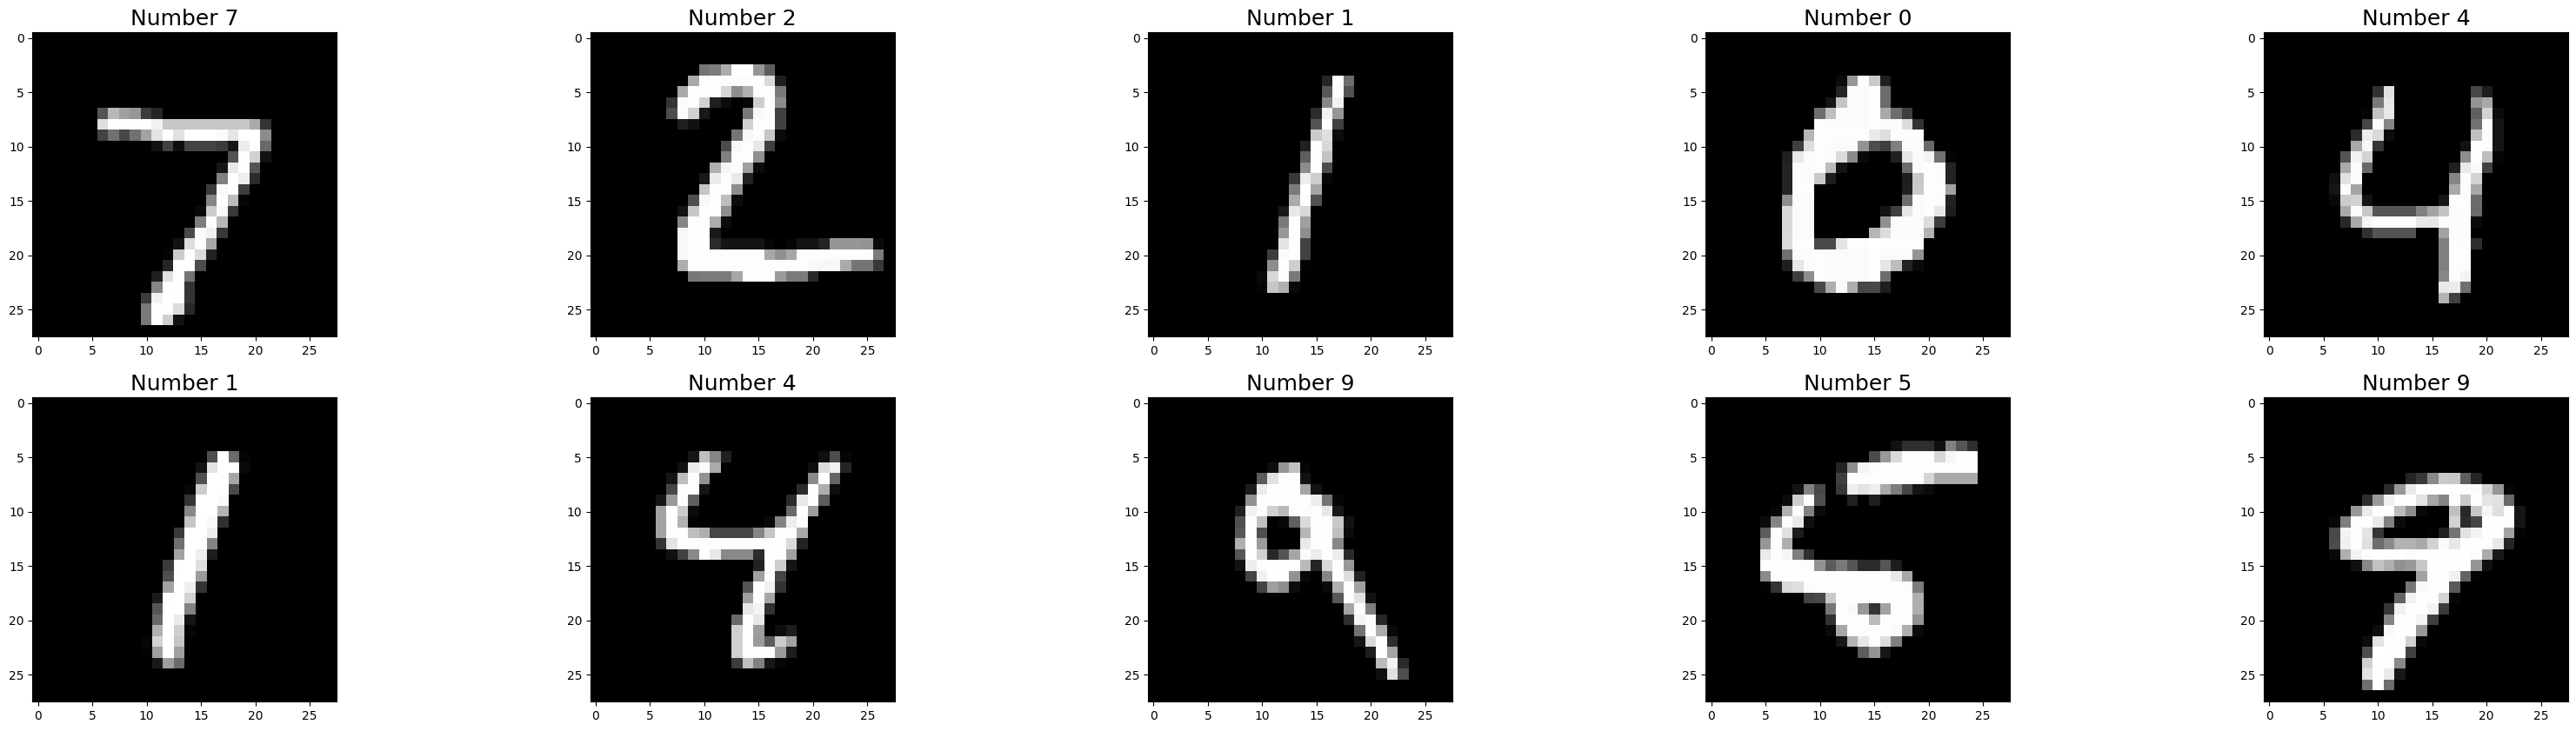

In [6]:
 #@title Testing block: Visualize the n training samples (ok).
n = 10
plt.figure(figsize=(40, n))
for input_image, ground_truth_label in test_dataloader:
  for i in range(n):
      plt.subplot(int(n/5), 5, i + 1)
      plt.imshow(input_image[i, 0, ...], cmap='gray')
      label_i = int(ground_truth_label[i])
      plt.title(f'Number {label_i}', fontsize=18)
  break

In [7]:
#@title Task 1: Start.

In [8]:
#@title Step 1: Setup a training device and define loss function (ok).
device = torch.device("cuda")

In [9]:
#@title Step 2: Define the network (ok).
class NeuralNetwork_CNN(nn.Module):
    def __init__(self, network_structure = None, lrate = 1e-2, epochs = 10, loss_fn_choice = None, optimizer_choice = None):
        super().__init__()

        if network_structure == None:
            self.network = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
                                                    # A convolutional network
                                                    # After this layer, the image is 28x28 with 32 channels
                nn.ReLU(),
                nn.MaxPool2d(2, 2),                  # nn.MaxPool2d(2, 2) is a 2x2 pooling layer
                                                    # After this layer, the image is 14x14 with 32 channels
                nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                                                    # After this layer, the image is still 14x14 with 32 channels
                nn.ReLU(),
                nn.MaxPool2d(2, 2),                  # After this layer, the image is ?x? with 32 channels
                nn.Flatten(),
                nn.Linear(7*7*32, 10)
            )
        else: self.network = network_structure

        self.lrate = lrate
        self.epochs = epochs
        self.loss_fn = nn.CrossEntropyLoss() if loss_fn_choice == None else loss_fn_choice
        self.optimizer = torch.optim.SGD(self.parameters(), self.lrate) if optimizer_choice == None else optimizer_choice

    def forward(self, x):
        return self.network(x)

    def load_params(self, load_path=None, device=None):
        if load_path is not None:
            try:
                self.load_state_dict(torch.load(load_path, map_location=device))
                print("Model parameters loaded successfully.")
            except Exception as e: print("Failed to load model parameters.")

    def save_params(self, save_path):
        try:
            torch.save(self.state_dict(), save_path)
            print("Model parameters saved successfully.")
        except Exception as e: print("Failed to save model parameters.")

In [10]:
#@title Step 3: Run the CNN-based network training job with 10 epochs (ok).

# Define and train models.
model_1 = NeuralNetwork_CNN().to(device)
accuracy_records_train_1 = []
accuracy_records_test_1 = []  # 2D array to store accuracy and epoch
for t in range(model_1.epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_1, model_1.loss_fn, model_1.optimizer)
    print("\n")

    accuracy_train_1 = error_performance(train_dataloader, model_1, model_1.loss_fn)
    accuracy_test_1 = error_performance(test_dataloader, model_1, model_1.loss_fn)
    accuracy_records_train_1.append([accuracy_train_1, t+1])
    accuracy_records_test_1.append([accuracy_test_1, t+1])
print("Done!")

Epoch 1
-------------------------------
loss: 2.298618  [   64/60000]
loss: 2.034222  [ 6464/60000]
loss: 0.890686  [12864/60000]
loss: 0.567875  [19264/60000]
loss: 0.455872  [25664/60000]
loss: 0.436440  [32064/60000]
loss: 0.282409  [38464/60000]
loss: 0.379930  [44864/60000]
loss: 0.453901  [51264/60000]
loss: 0.462783  [57664/60000]


----> Train accuracy: 88.2%, Avg loss: 0.360519!
----> Test accuracy: 89.1%, Avg loss: 0.341924!
Epoch 2
-------------------------------
loss: 0.282703  [   64/60000]
loss: 0.301962  [ 6464/60000]
loss: 0.223667  [12864/60000]
loss: 0.342929  [19264/60000]
loss: 0.185256  [25664/60000]
loss: 0.290245  [32064/60000]
loss: 0.155329  [38464/60000]
loss: 0.337501  [44864/60000]
loss: 0.327862  [51264/60000]
loss: 0.440035  [57664/60000]


----> Train accuracy: 92.1%, Avg loss: 0.249796!
----> Test accuracy: 92.9%, Avg loss: 0.235065!
Epoch 3
-------------------------------
loss: 0.179367  [   64/60000]
loss: 0.225485  [ 6464/60000]
loss: 0.168789  [12864

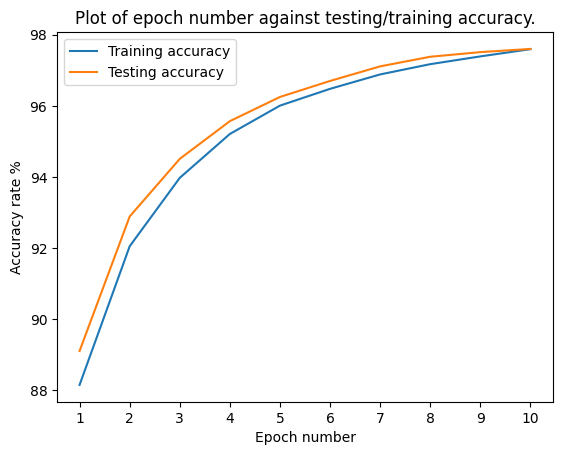

In [11]:
#@title Step 4: Plot the epoch(x-axis)-accuracy(y-axis) curve (ok).
def temp_plot_function(*arrays, legend = None):
    for data in arrays:
        x = [row[1] for row in data]
        y = [row[0] for row in data]

        plt.plot(x, y)

    plt.xlabel('Epoch number')
    plt.ylabel('Accuracy rate %')
    plt.title('Plot of epoch number against testing/training accuracy.')
    plt.legend(legend)
    plt.xticks(x)
    plt.show()

temp_plot_function(accuracy_records_train_1, accuracy_records_test_1, legend = ['Training accuracy', 'Testing accuracy'])

In [12]:
#@title Step 5: For both CNN-based networks, try different batch size (ok).
model_2 = NeuralNetwork_CNN(epochs = 5).to(device)
accuracy_records_train_2 = []
accuracy_records_test_2 = []
batchsize_accuracy_records_train_2 = []
batchsize_accuracy_records_test_2 = []
batch_size_array = [64 * i for i in range(1,11)]
elapsed_times = []  # List to store elapsed times
for i in batch_size_array:
    start_time = time.time()
    train_dataloader = DataLoader(training_data, batch_size=i)
    test_dataloader = DataLoader(test_data, batch_size=i)
    print(f'Start testing batch size {i}.')
    for t in range(model_2.epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model_2, model_2.loss_fn, model_2.optimizer)
        print('\n')
    print(f'Finish testing batch size {i}.')
    end_time = time.time()
    elapsed_times.append([end_time - start_time, i])
    accuracy_train_2 = error_performance(train_dataloader, model_2, model_2.loss_fn)
    accuracy_test_2 = error_performance(test_dataloader, model_2, model_2.loss_fn)
    batchsize_accuracy_records_train_2.append([accuracy_train_2, i])
    batchsize_accuracy_records_test_2.append([accuracy_test_2, i])
    print("\n")
# Set the batch size back to the default value --> 64
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
print("Done!")

Start testing batch size 64.
Epoch 1
-------------------------------
loss: 2.291852  [   64/60000]
loss: 1.857871  [ 6464/60000]
loss: 0.717470  [12864/60000]
loss: 0.532365  [19264/60000]
loss: 0.409025  [25664/60000]
loss: 0.429927  [32064/60000]
loss: 0.280933  [38464/60000]
loss: 0.388055  [44864/60000]
loss: 0.393023  [51264/60000]
loss: 0.451840  [57664/60000]


Epoch 2
-------------------------------
loss: 0.281504  [   64/60000]
loss: 0.293739  [ 6464/60000]
loss: 0.221918  [12864/60000]
loss: 0.353019  [19264/60000]
loss: 0.168318  [25664/60000]
loss: 0.286908  [32064/60000]
loss: 0.154178  [38464/60000]
loss: 0.328098  [44864/60000]
loss: 0.286926  [51264/60000]
loss: 0.424160  [57664/60000]


Epoch 3
-------------------------------
loss: 0.174775  [   64/60000]
loss: 0.204184  [ 6464/60000]
loss: 0.174551  [12864/60000]
loss: 0.298715  [19264/60000]
loss: 0.097035  [25664/60000]
loss: 0.211298  [32064/60000]
loss: 0.102909  [38464/60000]
loss: 0.296781  [44864/60000]
loss: 0

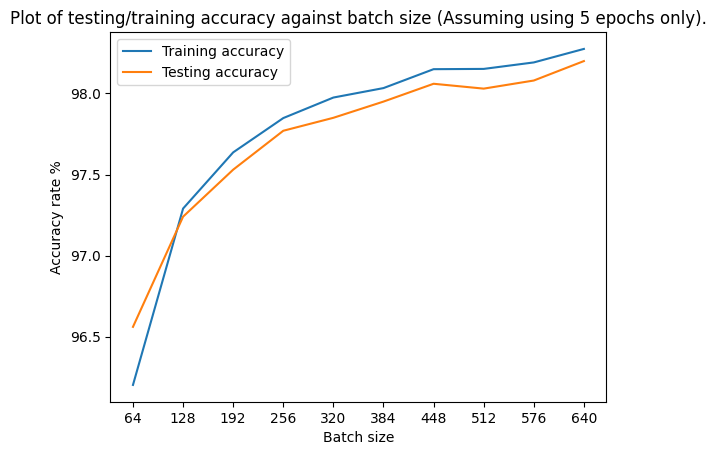

In [13]:
#@title Step 6: Plot of batchsize(x-axis)-accuracy(y-axis) curve (ok).
def temp_plot_function(*arrays, legend = None):
    for data in arrays:
        x = [row[1] for row in data]
        y = [row[0] for row in data]

        plt.plot(x, y)

    plt.xlabel('Batch size')
    plt.ylabel('Accuracy rate %')
    plt.title('Plot of testing/training accuracy against batch size (Assuming using 5 epochs only).')
    plt.legend(legend)
    plt.xticks(x)
    plt.show()
temp_plot_function(batchsize_accuracy_records_train_2, batchsize_accuracy_records_test_2, legend = ['Training accuracy', 'Testing accuracy'])

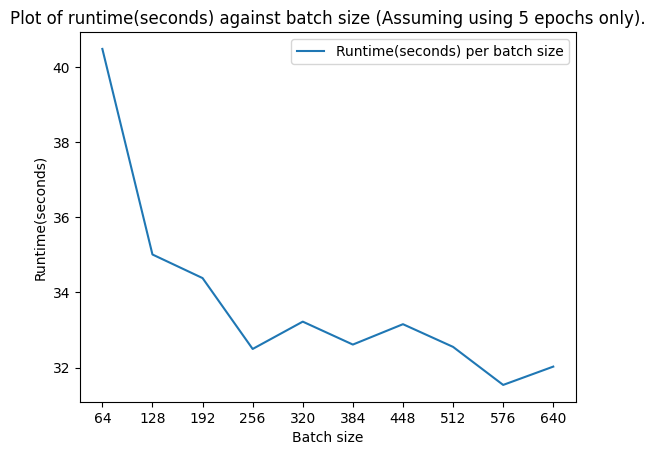

In [14]:
#@title Step 7: Plot of batchsize(x-axis)-runtime(y-axis) curve (ok).
def temp_plot_function(*arrays, legend = None):
    for data in arrays:
        x = [row[1] for row in data]
        y = [row[0] for row in data]

        plt.plot(x, y)

    plt.xlabel('Batch size')
    plt.ylabel('Runtime(seconds)')
    plt.title('Plot of runtime(seconds) against batch size (Assuming using 5 epochs only).')
    plt.legend(legend)
    plt.xticks(x)
    plt.show()

temp_plot_function(elapsed_times, legend = ['Runtime(seconds) per batch size'])

In [15]:
#@title Step 8: Explore the impact of different learning rates on accuracy (ok).
learning_rate_array = [i * (1e-3) / 2 for i in range(1, 11)]
model_3 = NeuralNetwork_CNN(epochs = 5).to(device)
accuracy_records_train_3 = []
accuracy_records_test_3 = []
for i in learning_rate_array:
    model_3.lrate = i
    print(f'Start testing learning rate {i}.')
    for t in range(model_3.epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model_3, model_3.loss_fn, model_3.optimizer)
        print("\n")
    print(f'Finish testing learning rate {i}.')
    accuracy_train_3 = error_performance(train_dataloader, model_3, model_3.loss_fn)
    accuracy_test_3 = error_performance(test_dataloader, model_3, model_3.loss_fn)
    accuracy_records_train_3.append([accuracy_train_3, i])
    accuracy_records_test_3.append([accuracy_test_3, i])
print("Done!")

Start testing learning rate 0.0005.
Epoch 1
-------------------------------
loss: 2.299966  [   64/60000]
loss: 2.131119  [ 6464/60000]
loss: 1.170283  [12864/60000]
loss: 0.627107  [19264/60000]
loss: 0.442554  [25664/60000]
loss: 0.431204  [32064/60000]
loss: 0.286033  [38464/60000]
loss: 0.405911  [44864/60000]
loss: 0.404999  [51264/60000]
loss: 0.464622  [57664/60000]


Epoch 2
-------------------------------
loss: 0.289195  [   64/60000]
loss: 0.310949  [ 6464/60000]
loss: 0.219255  [12864/60000]
loss: 0.349880  [19264/60000]
loss: 0.171934  [25664/60000]
loss: 0.300442  [32064/60000]
loss: 0.157732  [38464/60000]
loss: 0.347170  [44864/60000]
loss: 0.290660  [51264/60000]
loss: 0.434239  [57664/60000]


Epoch 3
-------------------------------
loss: 0.189768  [   64/60000]
loss: 0.216553  [ 6464/60000]
loss: 0.170469  [12864/60000]
loss: 0.300574  [19264/60000]
loss: 0.096357  [25664/60000]
loss: 0.228182  [32064/60000]
loss: 0.113415  [38464/60000]
loss: 0.304550  [44864/60000]


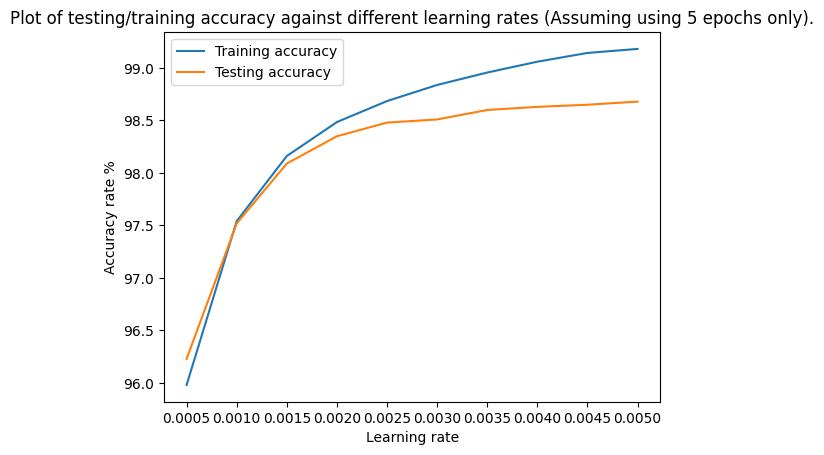

In [16]:
#@title Step 9: Plot of learning_rate(x-axis)-accuracy(y-axis) curve (ok).
def temp_plot_function(*arrays, legend = None):
    for data in arrays:
        x = [row[1] for row in data]
        y = [row[0] for row in data]

        plt.plot(x, y)

    plt.xlabel('Learning rate')
    plt.ylabel('Accuracy rate %')
    plt.title('Plot of testing/training accuracy against different learning rates (Assuming using 5 epochs only).')
    plt.legend(legend)
    plt.xticks(x)
    plt.show()
temp_plot_function(accuracy_records_train_3, accuracy_records_test_3, legend = ['Training accuracy', 'Testing accuracy'])

In [17]:
#@title Step 10: Explore the effect of different network structures on accuracy.
network_structure_1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
                                                    # A convolutional network
                                                    # After this layer, the image is 28x28 with 32 channels
    nn.Tanh(),
    nn.MaxPool2d(2, 2),                  # nn.MaxPool2d(2, 2) is a 2x2 pooling layer
                                        # After this layer, the image is 14x14 with 32 channels
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                                        # After this layer, the image is still 14x14 with 32 channels
    nn.Sigmoid(),
    nn.MaxPool2d(2, 2),                  # After this layer, the image is ?x? with 32 channels
    nn.Flatten(),
    nn.Linear(7*7*32, 10)
)

network_structure_2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
                                                    # A convolutional network
                                                    # After this layer, the image is 28x28 with 32 channels
    nn.Sigmoid(),
    nn.MaxPool2d(2, 2),                  # nn.MaxPool2d(2, 2) is a 2x2 pooling layer
                                        # After this layer, the image is 14x14 with 32 channels
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
                                        # After this layer, the image is still 14x14 with 32 channels
    nn.Sigmoid(),
    nn.MaxPool2d(2, 2),                  # After this layer, the image is ?x? with 32 channels
    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.Flatten(),
    nn.Linear(7*7*32, 10)
)

In [18]:
#@title Step 11: Train network_structure_1 (ok).
model_4 = NeuralNetwork_CNN(network_structure = network_structure_1, epochs = 10).to(device)
accuracy_records_train_4 = []
accuracy_records_test_4 = []  # 2D array to store accuracy and epoch
for t in range(model_4.epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_4, model_4.loss_fn, model_4.optimizer)
    print("\n")

    accuracy_train_4 = error_performance(train_dataloader, model_4, model_4.loss_fn)
    accuracy_test_4 = error_performance(test_dataloader, model_4, model_4.loss_fn)
    accuracy_records_train_4.append([accuracy_train_4, t+1])
    accuracy_records_test_4.append([accuracy_test_4, t+1])
print("Done!")

Epoch 1
-------------------------------
loss: 2.326470  [   64/60000]
loss: 2.285846  [ 6464/60000]
loss: 2.299976  [12864/60000]
loss: 2.311331  [19264/60000]
loss: 2.273852  [25664/60000]
loss: 2.214420  [32064/60000]
loss: 2.106460  [38464/60000]
loss: 1.989786  [44864/60000]
loss: 1.860137  [51264/60000]
loss: 1.490300  [57664/60000]


----> Train accuracy: 69.6%, Avg loss: 1.447288!
----> Test accuracy: 70.2%, Avg loss: 1.437246!
Epoch 2
-------------------------------
loss: 1.433421  [   64/60000]
loss: 1.157329  [ 6464/60000]
loss: 0.970584  [12864/60000]
loss: 0.926647  [19264/60000]
loss: 0.752874  [25664/60000]
loss: 0.771873  [32064/60000]
loss: 0.553437  [38464/60000]
loss: 0.649081  [44864/60000]
loss: 0.717317  [51264/60000]
loss: 0.574216  [57664/60000]


----> Train accuracy: 81.0%, Avg loss: 0.600847!
----> Test accuracy: 82.1%, Avg loss: 0.582412!
Epoch 3
-------------------------------
loss: 0.562503  [   64/60000]
loss: 0.481784  [ 6464/60000]
loss: 0.436842  [12864

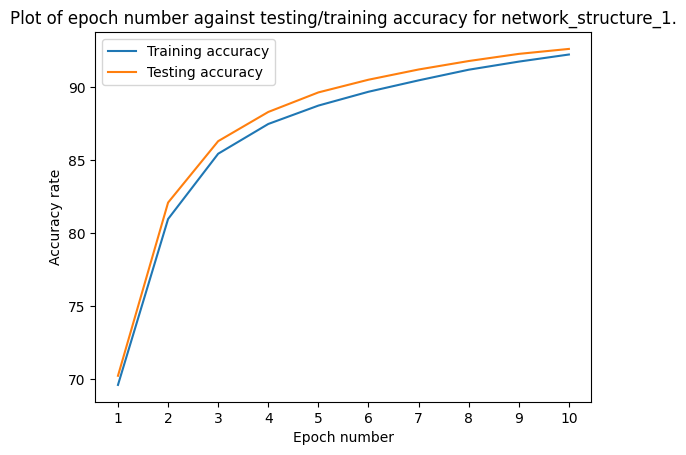

In [19]:
#@title Step 12: Plot the epoch(x-axis)-accuracy(y-axis) curve for network_structure_1 (ok).
def temp_plot_function(*arrays, legend = None):
    for data in arrays:
        x = [row[1] for row in data]
        y = [row[0] for row in data]

        plt.plot(x, y)

    plt.xlabel('Epoch number')
    plt.ylabel('Accuracy rate')
    plt.title('Plot of epoch number against testing/training accuracy for network_structure_1.')
    plt.legend(legend)
    plt.xticks(x)
    plt.show()

temp_plot_function(accuracy_records_train_4, accuracy_records_test_4, legend = ['Training accuracy', 'Testing accuracy'])

In [20]:
#@title Step 13: Train network_structure_2 (ok).
model_5 = NeuralNetwork_CNN(network_structure = network_structure_2, epochs = 10).to(device)
accuracy_records_train_5 = []
accuracy_records_test_5 = []  # 2D array to store accuracy and epoch
for t in range(model_5.epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_5, model_5.loss_fn, model_5.optimizer)
    print('\n')

    accuracy_train_5 = error_performance(train_dataloader, model_5, model_5.loss_fn)
    accuracy_test_5 = error_performance(test_dataloader, model_5, model_5.loss_fn)
    accuracy_records_train_5.append([accuracy_train_5, t+1])
    accuracy_records_test_5.append([accuracy_test_5, t+1])
print("Done!")

Epoch 1
-------------------------------
loss: 2.312887  [   64/60000]
loss: 2.296273  [ 6464/60000]
loss: 2.318135  [12864/60000]
loss: 2.308853  [19264/60000]
loss: 2.310603  [25664/60000]
loss: 2.308181  [32064/60000]
loss: 2.296947  [38464/60000]
loss: 2.305290  [44864/60000]
loss: 2.302541  [51264/60000]
loss: 2.291964  [57664/60000]


----> Train accuracy: 14.6%, Avg loss: 2.297676!
----> Test accuracy: 14.3%, Avg loss: 2.297446!
Epoch 2
-------------------------------
loss: 2.298709  [   64/60000]
loss: 2.293191  [ 6464/60000]
loss: 2.309114  [12864/60000]
loss: 2.299395  [19264/60000]
loss: 2.301403  [25664/60000]
loss: 2.299876  [32064/60000]
loss: 2.287909  [38464/60000]
loss: 2.299412  [44864/60000]
loss: 2.293578  [51264/60000]
loss: 2.281311  [57664/60000]


----> Train accuracy: 20.1%, Avg loss: 2.286633!
----> Test accuracy: 20.0%, Avg loss: 2.286214!
Epoch 3
-------------------------------
loss: 2.287842  [   64/60000]
loss: 2.280105  [ 6464/60000]
loss: 2.292172  [12864

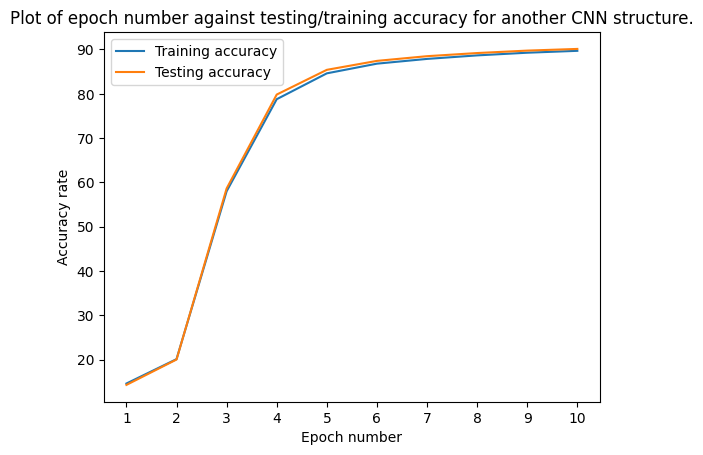

In [21]:
#@title Step 14: Plot the epoch(x-axis)-accuracy(y-axis) curve for network_structure_2 (ok).
def temp_plot_function(*arrays, legend = None):
    for data in arrays:
        x = [row[1] for row in data]
        y = [row[0] for row in data]

        plt.plot(x, y)

    plt.xlabel('Epoch number')
    plt.ylabel('Accuracy rate')
    plt.title('Plot of epoch number against testing/training accuracy for another CNN structure.')
    plt.legend(legend)
    plt.xticks(x)
    plt.show()

temp_plot_function(accuracy_records_train_5, accuracy_records_test_5, legend = ['Training accuracy', 'Testing accuracy'])

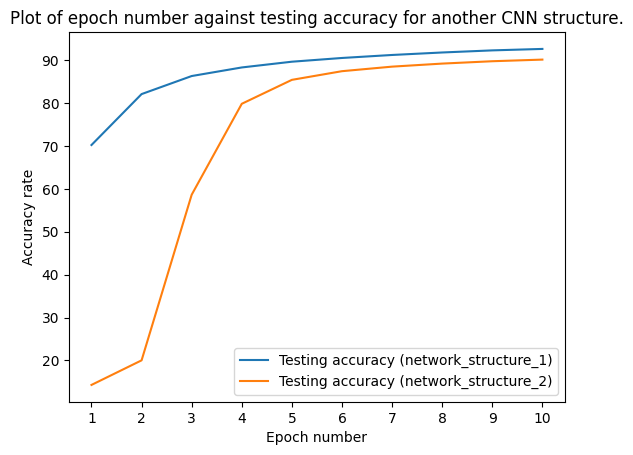

In [22]:
#@title Step 15: Plot the epoch(x-axis)-testing accuracy(y-axis) between network_structure_1 and network_structure_2 (ok).
def temp_plot_function(*arrays, legend = None):
    for data in arrays:
        x = [row[1] for row in data]
        y = [row[0] for row in data]

        plt.plot(x, y)

    plt.xlabel('Epoch number')
    plt.ylabel('Accuracy rate')
    plt.title('Plot of epoch number against testing accuracy for another CNN structure.')
    plt.legend(legend)
    plt.xticks(x)
    plt.show()

temp_plot_function(accuracy_records_test_4, accuracy_records_test_5, legend = ['Testing accuracy (network_structure_1)', 'Testing accuracy (network_structure_2)'])

In [ ]:
#@title Task 2: Utilize the input images in the MNIST dataset (ignore the labels) to build a denoising training dataset and train a denoising network (ok).

In [23]:
#@title Step 1: Load and transform the MNIST dataset (ok).
sigma = 40 #@param
def transform_data(dt):
    data_list = []
    label_list = []
    def resize_tensor(tensor, desired_size = (32, 32)):
        resized_tensor = nn.functional.interpolate(tensor.unsqueeze(0).unsqueeze(0), size=desired_size, mode='bilinear', align_corners=False)
        return resized_tensor.squeeze(0).squeeze(0)
    for i in range(len(dt.data)):
        temp = resize_tensor(dt.data[i]).float()
        label_list += [temp.unsqueeze(0)]
        data_list += [torch.clamp(temp + sigma * torch.randn(temp.shape[0], temp.shape[1]), 0, 255).unsqueeze(0)]
    return torch.stack(data_list), torch.stack(label_list)

data_transform_basic = tfs.Compose([
    tfs.ToTensor(),
])

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=data_transform_basic
)

training_data_list, training_label_list = transform_data(training_data)
training_data_2 = TensorDataset(training_data_list, training_label_list)

testing_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=data_transform_basic
)
testing_data_list, testing_label_list = transform_data(testing_data)
testing_data_2 = TensorDataset(testing_data_list, testing_label_list)

# Create data loaders.
batch_size = 64
training_dataloader_2 = DataLoader(training_data_2, batch_size=batch_size)
testing_dataloader_2 = DataLoader(testing_data_2, batch_size=batch_size)

In [24]:
#@title Testing block (ok).
for batch in training_dataloader_2:
    data, labels = batch
    # Perform your operations with the data and labels
    print('Data batch:', data.shape, data.dtype)
    print('Label batch:', labels.shape, labels.dtype)
    print('---')
    break

Data batch: torch.Size([64, 1, 32, 32]) torch.float32
Label batch: torch.Size([64, 1, 32, 32]) torch.float32
---


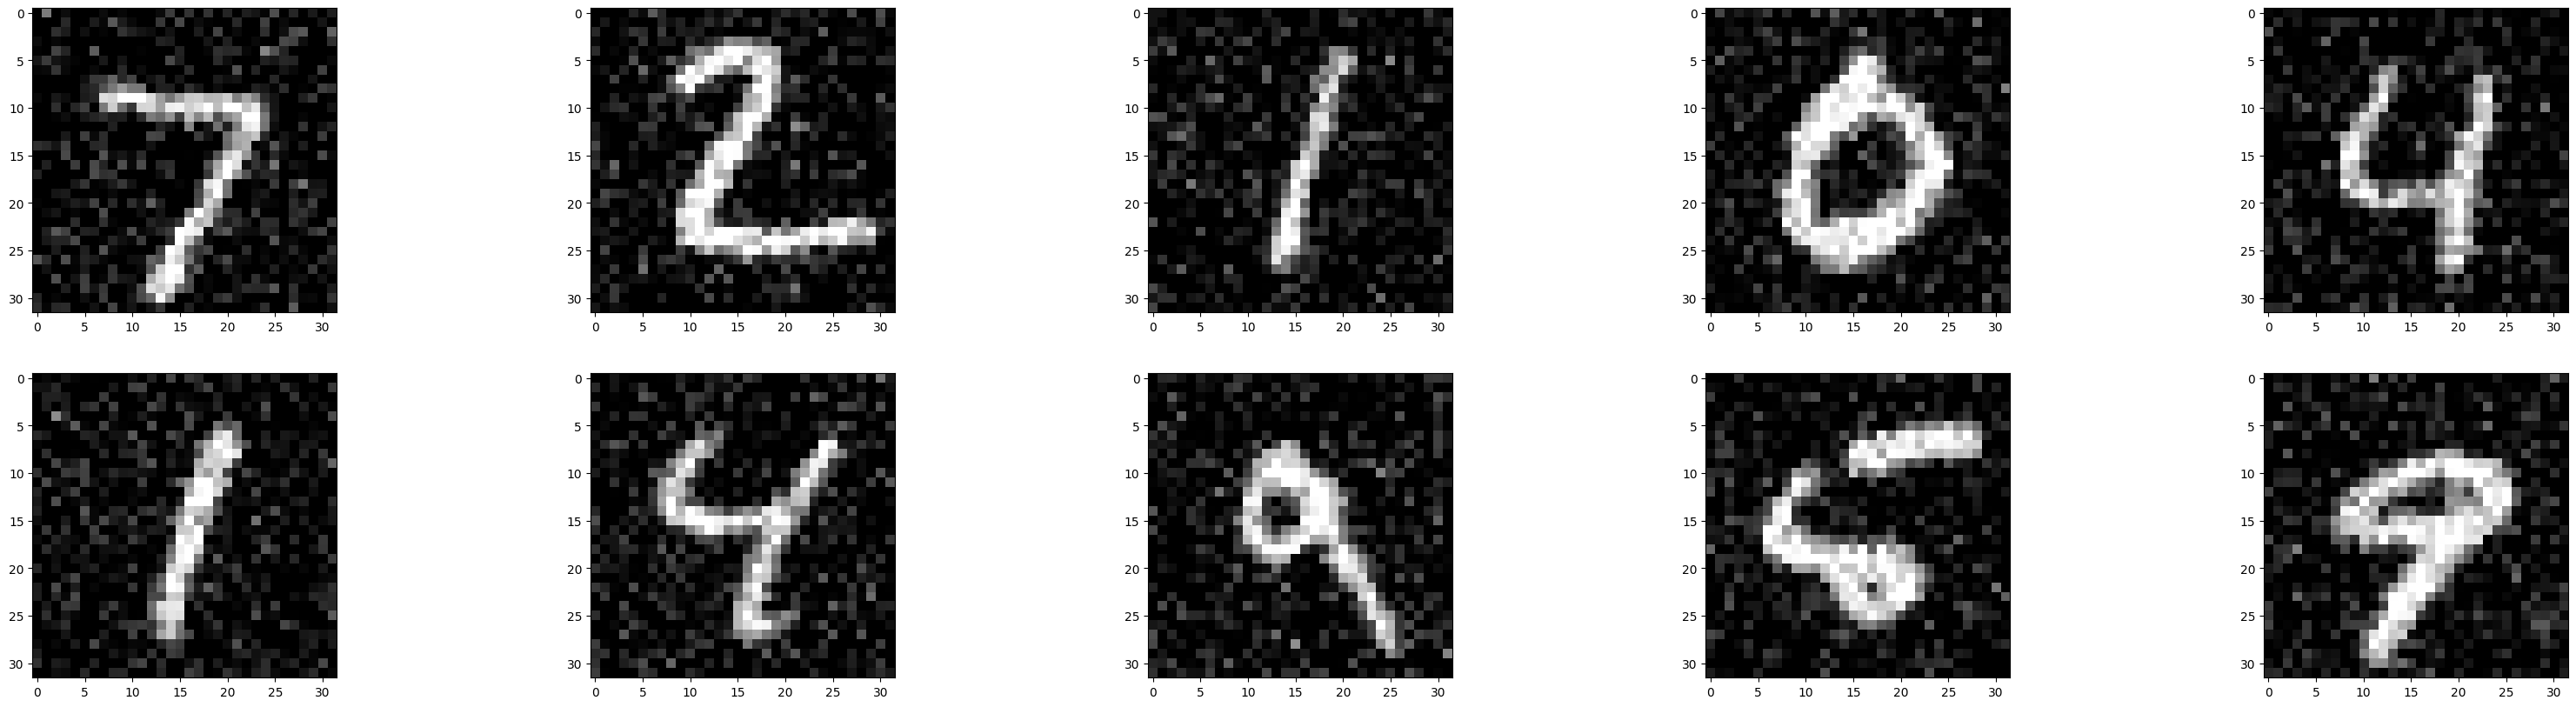

In [25]:
#@title Testing block (ok).
n = 10
plt.figure(figsize=(40, n))
for input_image, ground_truth_label in testing_dataloader_2:
    for i in range(n):
        plt.subplot(int(n/5), 5, i + 1)
        plt.imshow(input_image[i,0,...], cmap='gray')  # Display the image with three channels
    break

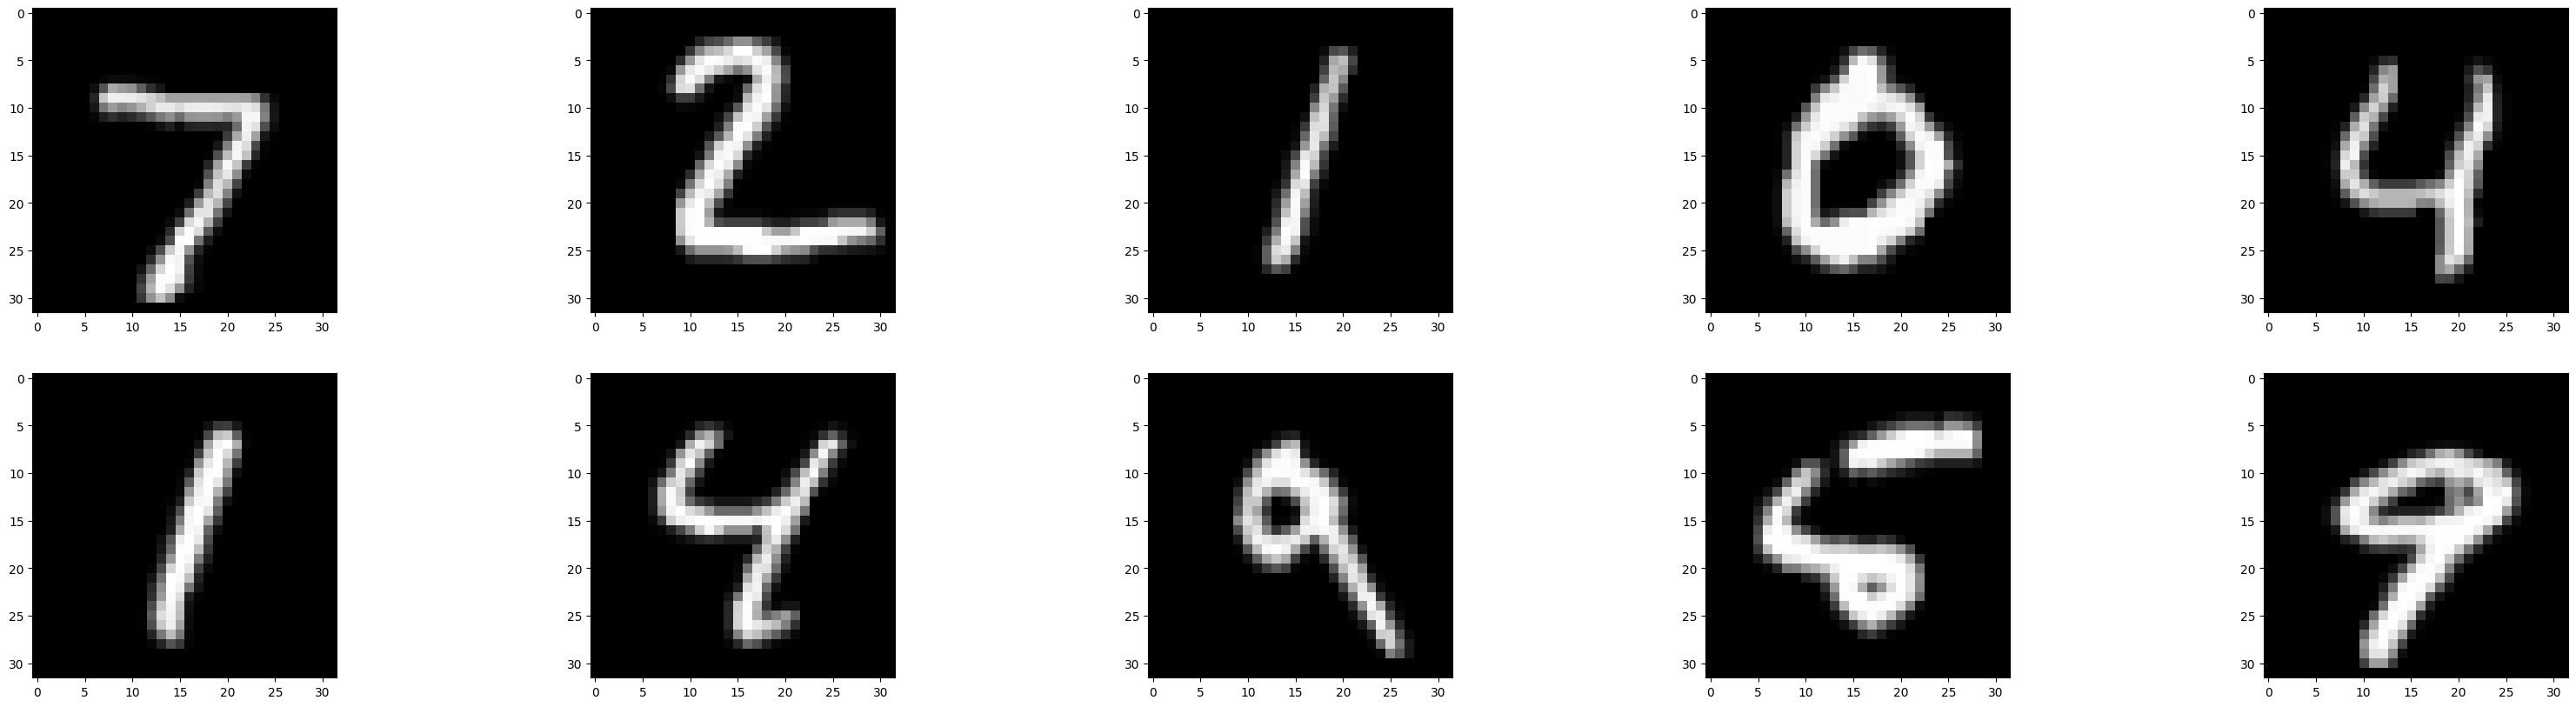

In [26]:
#@title Testing block (ok).
n = 10
plt.figure(figsize=(40, n))
for input_image, ground_truth_label in testing_dataloader_2:
    for i in range(n):
        plt.subplot(int(n/5), 5, i + 1)
        plt.imshow(ground_truth_label[i,0,...], cmap='gray')  # Display the image with three channels
    break

In [27]:
#@title Step 2: Define unet structure (ok).
# Step 2.1: Define essential parameters.
model_save_path = 'unet_model_2.pt'
device = torch.device("cuda")

# Step 2.2: Define model structure
class Asm3_U_Net(nn.Module):
    def __init__(self, in_channels, num_classes, lrate=3e-4, epochs=10, loss_fn_choice=None, optimizer_choice=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1) # ok
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # ok
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # ok
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # ok
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1) # ok
        self.up1 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2) # ok
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, padding=1)  # ok
        self.up2 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2) # ok
        self.conv5 = nn.Conv2d(48, 32, kernel_size=3, padding=1)  # ok
        self.last_conv = nn.Conv2d(32, num_classes, kernel_size=1)

        self.lrate = lrate
        self.epochs = epochs
        self.loss_fn = nn.MSELoss() if loss_fn_choice is None else loss_fn_choice
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=lrate) if optimizer_choice is None else optimizer_choice

    def forward(self, x):
        # print("-" * 40)
        # print("Layer 1:")
        # print('Input size:', x.size())
        a = F.relu(self.conv1(x))
        # print("Output size:", a.size())

        # print("-" * 40)
        # print("Layer 2:")
        # print('Input size:', a.size())
        b = self.pool1(a)
        # print("Output size:", b.size())

        # print("-" * 40)
        # print("Layer 3:")
        # print('Input size:', b.size())
        c = F.relu(self.conv2(b))
        # print("Output size:", c.size())

        # print("-" * 40)
        # print("Layer 4:")
        # print('Input size:', c.size())
        d = self.pool2(c)
        # print("Output size:", d.size())

        # print("-" * 40)
        # print("Layer 5:")
        # print('Input size:', d.size())
        e = F.relu(self.conv3(d))
        # print("Output size:", e.size())

        # print("-" * 40)
        # print("Layer 6:")
        # print('Input size:', e.size())
        f = self.up1(e)
        # print("Output size:", f.size())

        # print("-" * 40)
        # print("Layer 7:")
        # print('Input size:', f.size())
        g = torch.cat([c, f], dim = 1)
        # print("Output size:", g.size())

        # print("-" * 40)
        # print("Layer 8:")
        # print('Input size:', g.size())
        h = F.relu(self.conv4(g))
        # print("Output size:", h.size())

        # print("-" * 40)
        # print("Layer 9:")
        # print('Input size:', h.size())
        i = self.up2(h)
        # print("Output size:", i.size())

        # print("-" * 40)
        # print("Layer 10:")
        # print('Input size:', i.size())
        j = torch.cat([a, i], dim = 1)
        # print("Output size:", j.size())

        # print("-" * 40)
        # print("Layer 11:")
        # print('Input size:', j.size())
        k = F.relu(self.conv5(j))
        # print("Output size:", k.size())

        # print("-" * 40)
        # print("Layer 12 (Last layer):")
        # print('Input size:', k.size())
        l = F.relu(self.last_conv(k))
        # print("Output size:", l.size())

        return l

    def load_params(self, load_path=None, device=None):
        if load_path is not None:
            try:
                self.load_state_dict(torch.load(load_path, map_location=device))
                print("Model parameters loaded successfully.")
            except Exception as e: print("Failed to load model parameters.")

    def save_params(self, save_path):
        try:
            torch.save(self.state_dict(), save_path)
            print("Model parameters saved successfully.")
        except Exception as e: print("Failed to save model parameters.")


In [28]:
#@title Testing block (ok).
input_image = torch.rand((64,1,32,32))
model_1 = Asm3_U_Net(1, 1)
output = model_1(input_image)
print(output.size())

torch.Size([64, 1, 32, 32])


In [29]:
#@title Step 3: Run the unet model with 2 epoch (ok).

# Define and train models.
unet_model_1 = Asm3_U_Net(in_channels=1, num_classes=1).to(device)
for t in range(unet_model_1.epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(training_dataloader_2, unet_model_1, unet_model_1.loss_fn, unet_model_1.optimizer)
    print("\n")

unet_model_1.save_params(model_save_path)
print("Done!")

Epoch 1
-------------------------------
loss: 6339.711426  [   64/60000]
loss: 132.851013  [ 6464/60000]
loss: 107.320160  [12864/60000]
loss: 109.355484  [19264/60000]
loss: 102.787491  [25664/60000]
loss: 98.337822  [32064/60000]
loss: 89.364349  [38464/60000]
loss: 87.643570  [44864/60000]
loss: 81.179626  [51264/60000]
loss: 77.146721  [57664/60000]


Epoch 2
-------------------------------
loss: 82.174797  [   64/60000]
loss: 78.584839  [ 6464/60000]
loss: 75.822922  [12864/60000]
loss: 84.065445  [19264/60000]
loss: 81.475906  [25664/60000]
loss: 78.734528  [32064/60000]
loss: 71.152664  [38464/60000]
loss: 71.966957  [44864/60000]
loss: 69.228088  [51264/60000]
loss: 68.791435  [57664/60000]


Model parameters saved successfully.
Done!


In [30]:
# Step 3.5: ...
unet_model_2 = Asm3_U_Net(in_channels=1, num_classes=1).to(device)
unet_model_2.load_params(model_save_path, device)
unet_model_2.eval()

Model parameters loaded successfully.


U_Net(
  (down_conv_1): down_sample(
    (conv): two_conv_relu(
      (conv_op): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_conv_2): down_sample(
    (conv): two_conv_relu(
      (conv_op): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_conv_3): down_sample(
    (conv): two_conv_relu(
      (conv_op): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

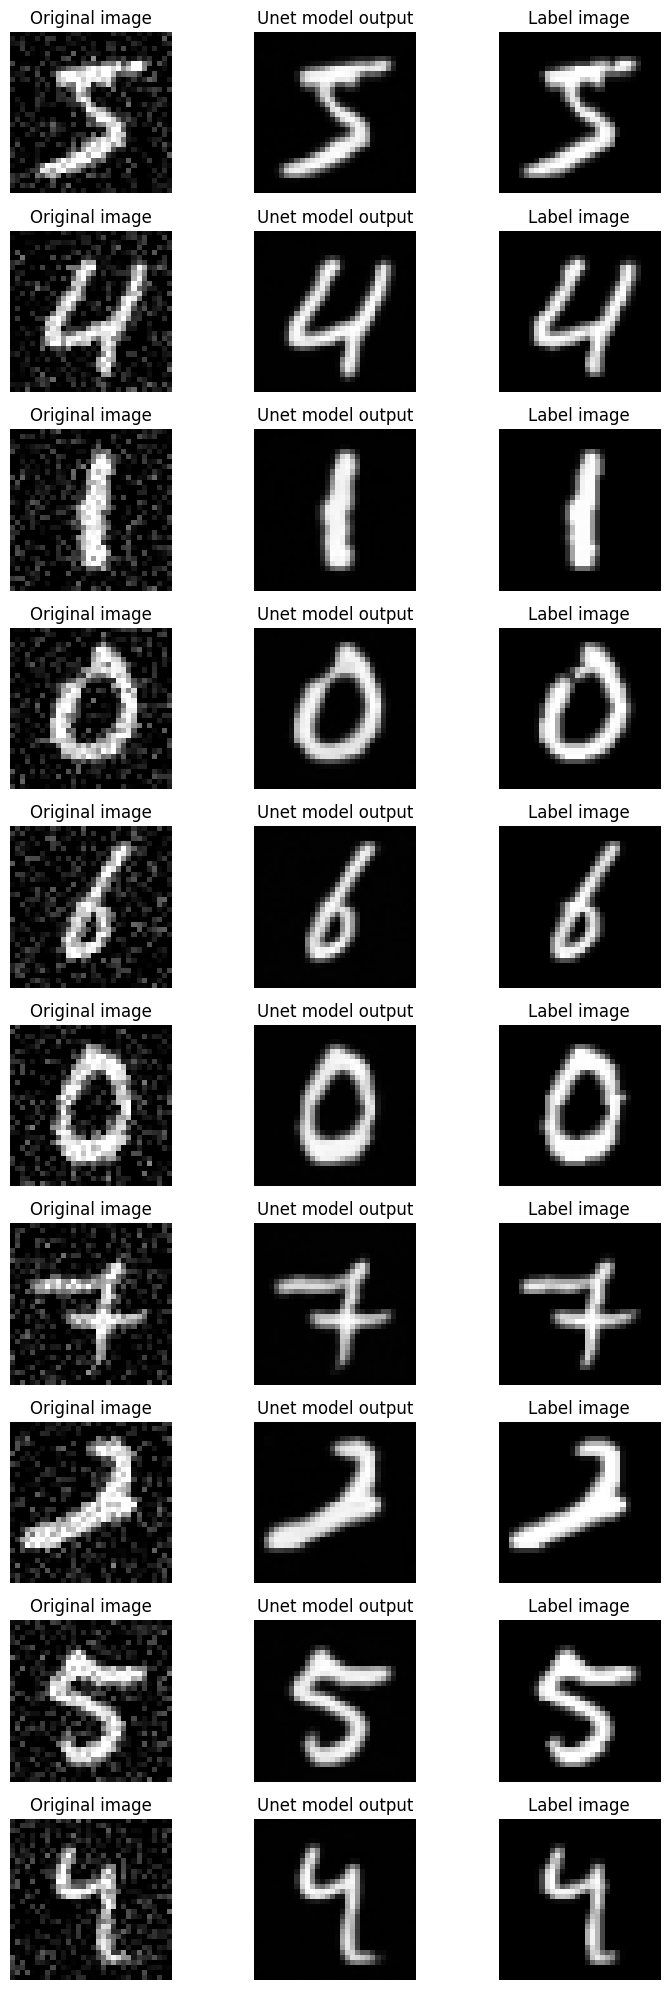

In [31]:
#@title Step 4: Visualize training result (ok).

fig, axs = plt.subplots(10, 3, figsize=(8, 20))

for i, batch in enumerate(training_dataloader_2):
    if i >= 10:
        break

    data, labels = batch

    # Perform your operations with the data and labels
    # print('Data batch:', data.shape, data.dtype)
    # print('Label batch:', labels.shape, labels.dtype)
    data = data.to(device)

    output = unet_model_2(data)

    image_output = output[0, 0].detach().cpu().numpy()
    image_data = data[0, 0].detach().cpu().numpy()
    label_data = labels[0, 0].detach().cpu().numpy()
    # print(torch.sum(torch.sqrt((torch.from_numpy(label_data) - torch.from_numpy(image_output))**2)).item())

    # Plotting the images
    axs[i, 1].imshow(image_output, cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title('Unet model output')

    axs[i, 0].imshow(image_data, cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Original image')

    axs[i, 2].imshow(label_data, cmap='gray')
    axs[i, 2].axis('off')
    axs[i, 2].set_title('Label image')

plt.tight_layout()
plt.show()

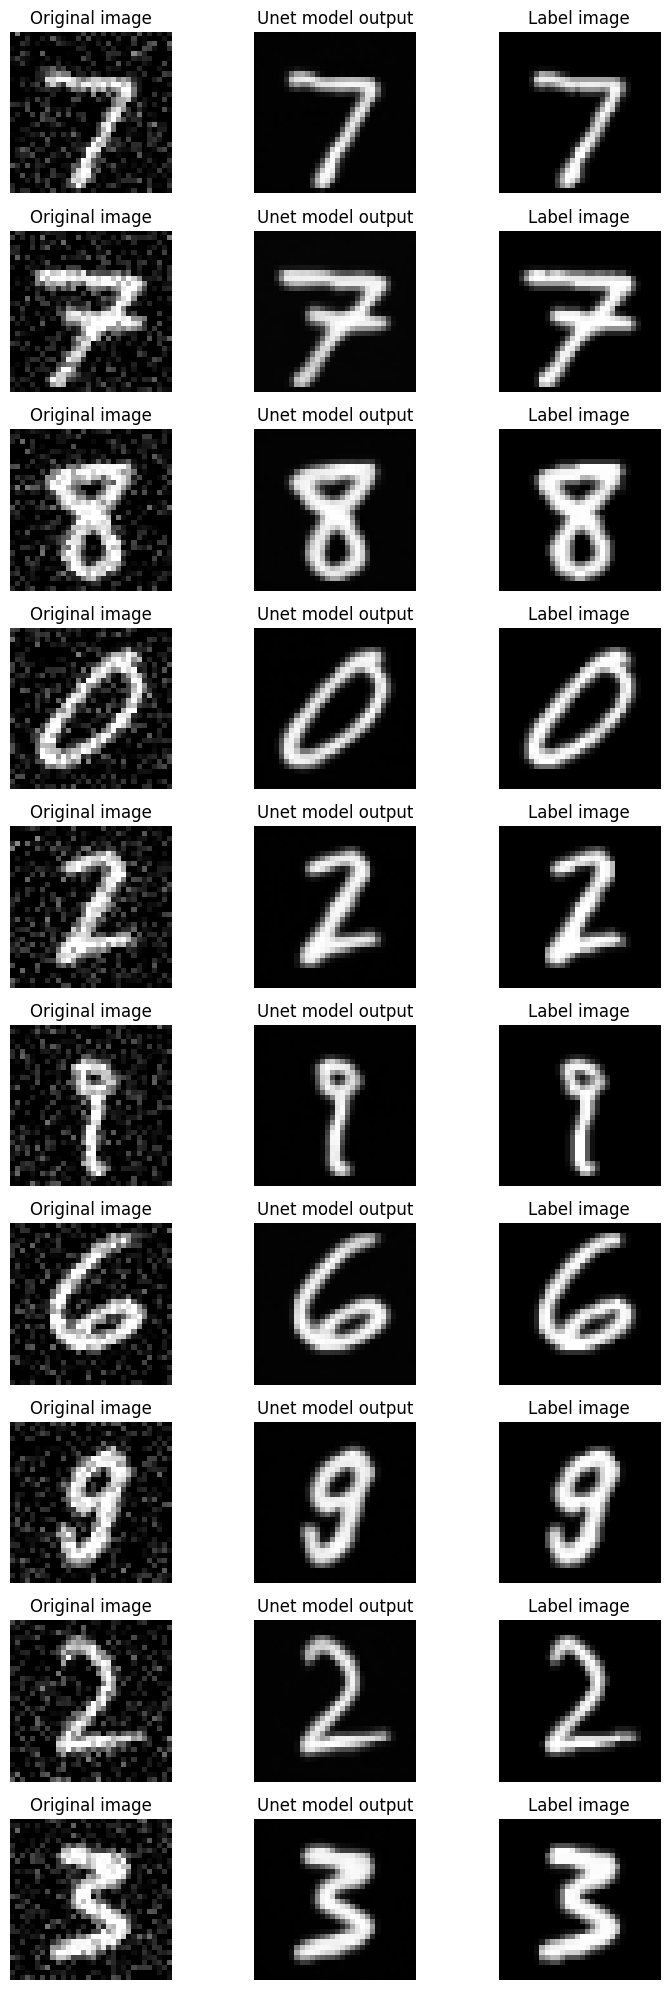

In [32]:
#@title Step 5: Visualize testing result (ok).

fig, axs = plt.subplots(10, 3, figsize=(8, 20))

for i, batch in enumerate(testing_dataloader_2):
    if i >= 10:
        break

    data, labels = batch

    # Perform your operations with the data and labels
    # print('Data batch:', data.shape, data.dtype)
    # print('Label batch:', labels.shape, labels.dtype)
    data = data.to(device)

    output = unet_model_2(data)

    image_output = output[0, 0].detach().cpu().numpy()
    image_data = data[0, 0].detach().cpu().numpy()
    label_data = labels[0, 0].detach().cpu().numpy()
    # print(torch.sum(torch.sqrt((torch.from_numpy(label_data) - torch.from_numpy(image_output))**2)).item())

    # Plotting the images
    axs[i, 1].imshow(image_output, cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 1].set_title('Unet model output')

    axs[i, 0].imshow(image_data, cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Original image')

    axs[i, 2].imshow(label_data, cmap='gray')
    axs[i, 2].axis('off')
    axs[i, 2].set_title('Label image')

plt.tight_layout()
plt.show()

In [33]:
#@title Step 6: Try the model on other images (ok).
def png_to_tensor(image_path):
    # Open the PNG image using PIL
    image = Image.open(image_path).convert('L')  # Convert to grayscale

    # Resize the image to 32x32 pixels
    resize_transform = tfs.Resize((32, 32))
    image = resize_transform(image)

    # Increase contrast of the image
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(2.0)  # Increase contrast by a factor of 2

    # Convert the image to a tensor without normalization
    transform = tfs.ToTensor()
    tensor = transform(image).unsqueeze(0)

    # Scale the tensor values to the range of 0-255
    tensor = tensor * 255.0

    # Convert the tensor to integer type
    tensor = tensor.to(torch.float32).to(device)

    # Check tensor size
    print(tensor.shape)
    return tensor

def show_image(image):
    image_np = image.squeeze().detach().cpu().numpy()

    # Plot the image
    plt.imshow(image_np, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.show()

torch.Size([1, 1, 32, 32])


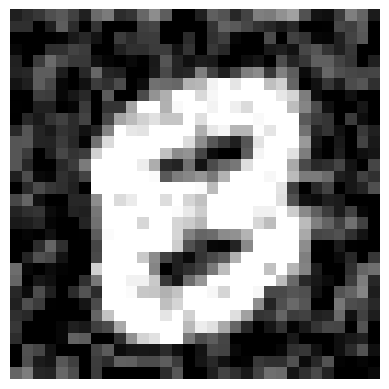

In [34]:
#@title Step 7: Show the raw image (ok).
# Path to the PNG image
pic_path = 'Testing_pic.png'

# Convert PNG image to tensor.
processed_pic = png_to_tensor(pic_path)

# Show the processed image.
show_image(processed_pic)

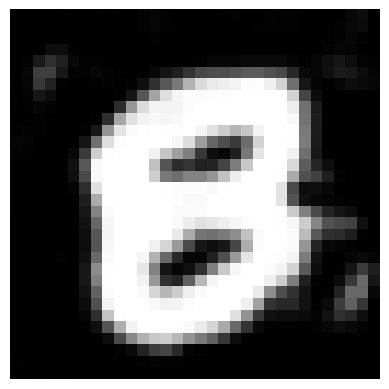

In [35]:
#@title Step 8: Show the predicted image (ok).
show_image(unet_model_2(processed_pic))